In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from scipy.cluster import hierarchy

## Concept shift or Data shift:
1) We usually train our model on past data,however purchase behaviour and fraudster strategies may change over time. 
2) This phenomenon is named dataset shift or concept drift in the domain of fraud detection.
3) We are creating a new feature to tackle above dataset shift problem in credit card transactions
4) In practice, we classify the days against each other and measure the efficiency of the classification. The more efficient the classification, the more different the buying
behaviour between two days, and vice versa.
5) The classification is evaluated using the Matthews correla- tion coefficient (MCC). The MCC is a confusion matrix based metric that can take values between -1 and 1. 
6) A value of MCC close to 1 means that the classifier is good at differenciating the pair of days considered, the days are easy to differenciate since there is a dataset shift between them.
7) MCC value is used in order to build a 182x182 distance matrix characterizing the covariate shift between the 182 days of the dataset.Therefore, we obtain a distance matrix characterizing the dataset shift.
8) We perform agglomerative clustering of the distance matrix, using no of clusters as 4
(weekdays,saturday,sunday,holiday) as buying behaviours are impacted on calender events.
9) We then incorporate this dataset shift knowledge in the credit card fraud detection task as a new feature. 
* **Reference:**
    * https://arxiv.org/pdf/1906.06977.pdf

In [28]:
# load pickled data
df_train = pd.read_pickle('df_train.pkl')
df_test= pd.read_pickle('df_test.pkl')

In [4]:
# create an empty distance matrix
distance_matrix=np.zeros((182, 182))

In [5]:
''' for each day in dataset
    we split 80 percent of transactions done on that day as train1
    20 percent as test1 and compare this day with 
        for every other day in dataset 
        by taking 80-20 of days transaction as train2 and test2
        combine train1 and train2 and test1 and test2 data 
        we fit this stacked data on randomforest classifier
        using test data we predic class labes
        MCC metric takes actual and predicted y labels gives a float value b/w -1 to +1
        we update distance matrix
'''

for row in df_train['day'].unique():
    length=int(len(df_train.loc[df_train['day']==row])*0.8)
    X_train1=df_train.loc[df_train['day']==row].drop(['TransactionID','day','week','week2','hour','isFraud'],axis=1)[:length]
    X_test1 =df_train.loc[df_train['day']==row].drop(['TransactionID','day','week','week2','hour','isFraud'],axis=1)[length:]
    y_train1=df_train.loc[df_train['day']==row]['day'][:length]
    y_actual1=df_train.loc[df_train['day']==row]['day'][length:]
    for column in df_train['day'].unique():
        length1=int(len(df_train.loc[df_train['day']==column])*0.8)
        X_train2=df_train.loc[df_train['day']==column].drop(['TransactionID','day','week','week2','hour','isFraud'],axis=1)[:length1]
        X_test2 =df_train.loc[df_train['day']==column].drop(['TransactionID','day','week','week2','hour','isFraud'],axis=1)[length1:]
        y_train2=df_train.loc[df_train['day']==column]['day'][:length1]
        y_actual2=df_train.loc[df_train['day']==column]['day'][length1:]
        X_train=np.vstack((X_train1,X_train2))
        X_test=np.vstack((X_test1,X_test2))
        y_train=np.concatenate((y_train1.values,y_train2.values))
        y_actual=np.concatenate((y_actual1.values,y_actual2.values))
        clf = RandomForestClassifier(max_depth=100, random_state=0,min_samples_leaf=10)
        clf.fit(X_train, y_train)
        y_predicted=clf.predict(X_test)
        distance_matrix[row-1][column-1]=matthews_corrcoef(y_actual, y_predicted)

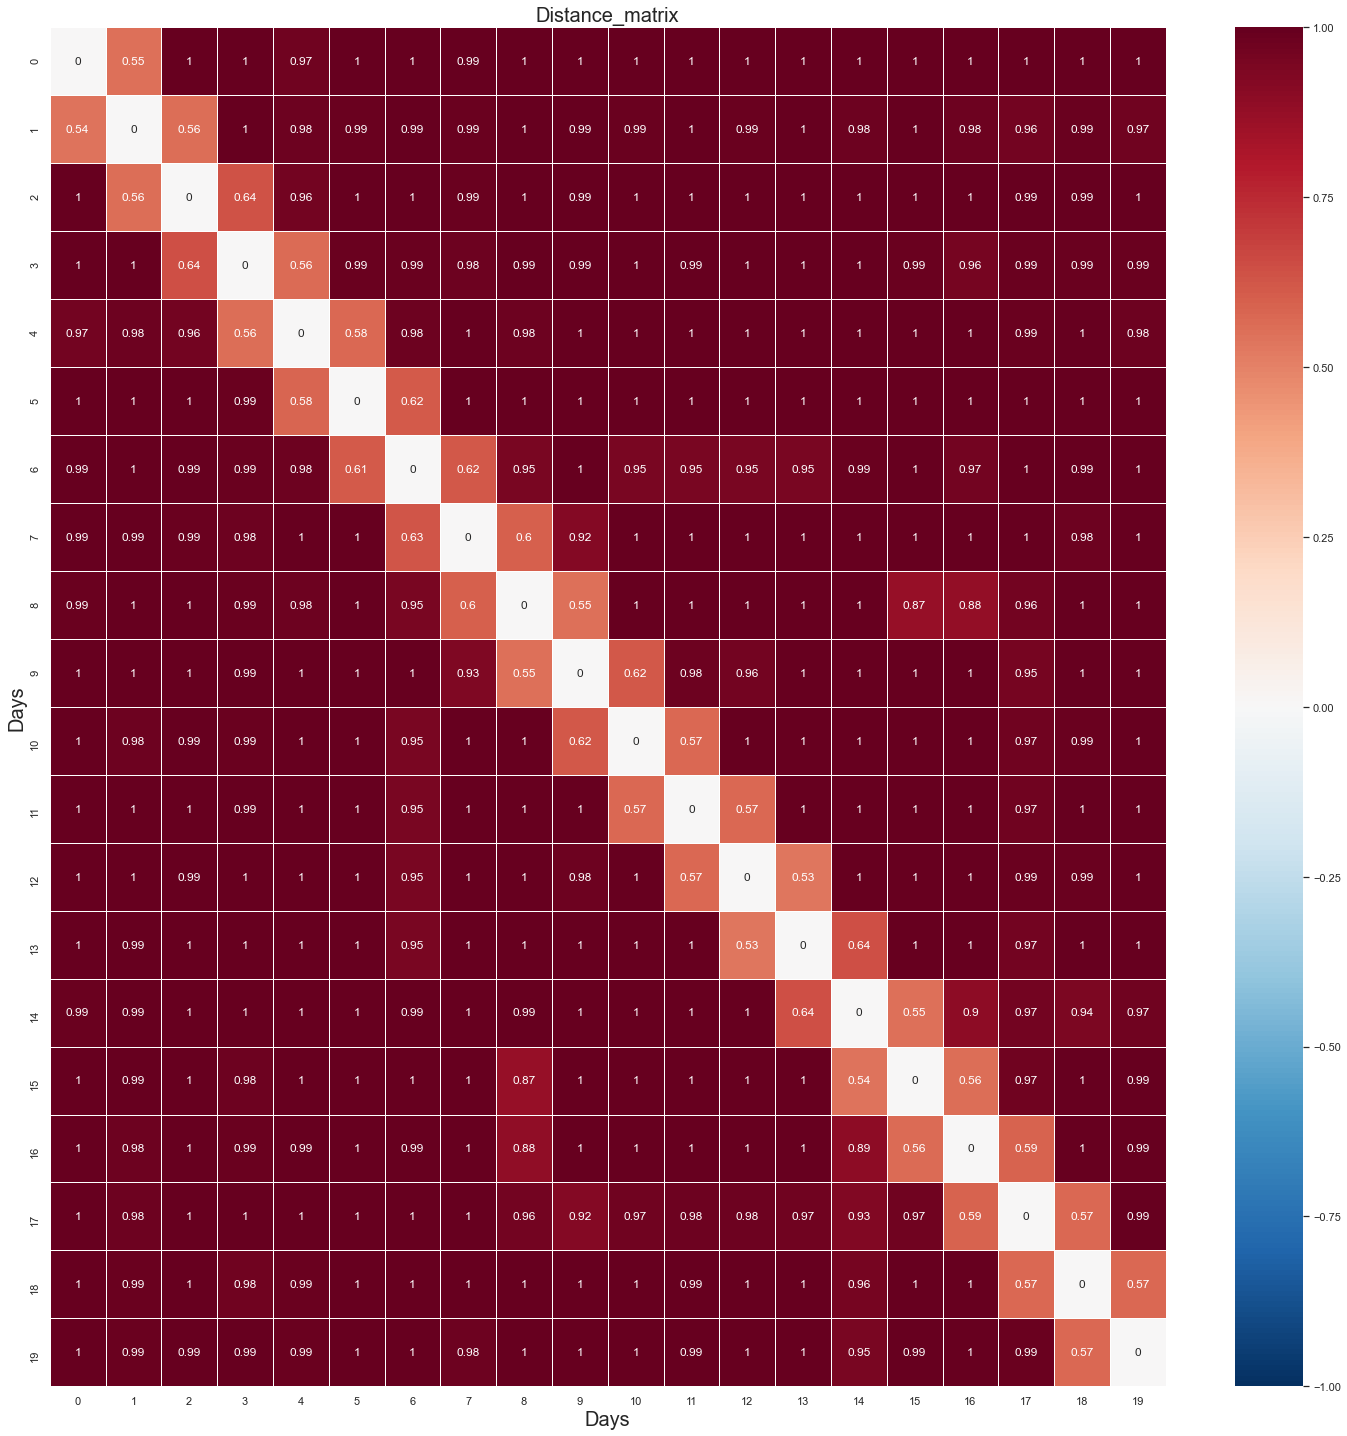

In [6]:
sns.set(rc={'figure.figsize': (25,25)})
sns.heatmap(distance_matrix[:20,:20], cmap="RdBu_r", annot=True, linewidths=1,vmin = -1 , vmax = 1)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Days',fontsize=20)
plt.title('Distance_matrix',fontsize=20)
plt.show()

## Create new feature from cluster labels

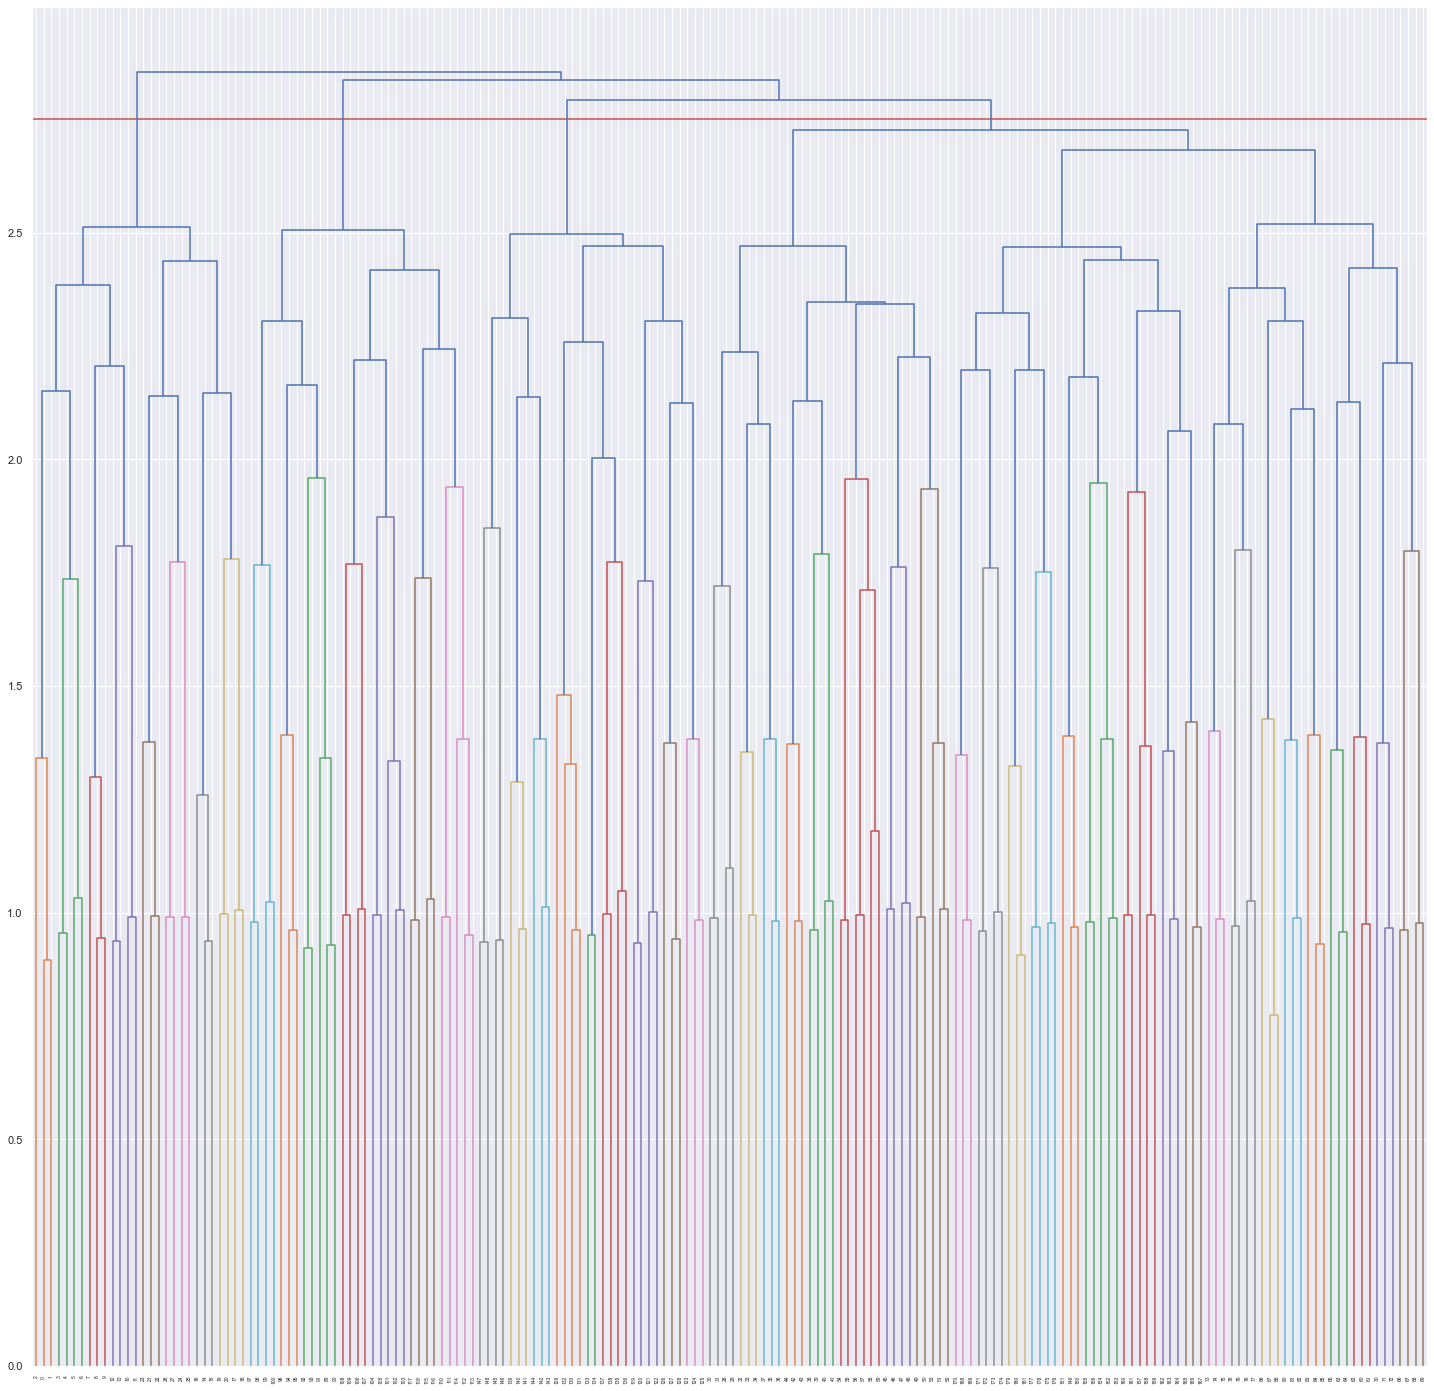

In [60]:
Z = hierarchy.linkage(distance_matrix, 'ward')
plt.figure()
plt.axhline(y =2.75, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

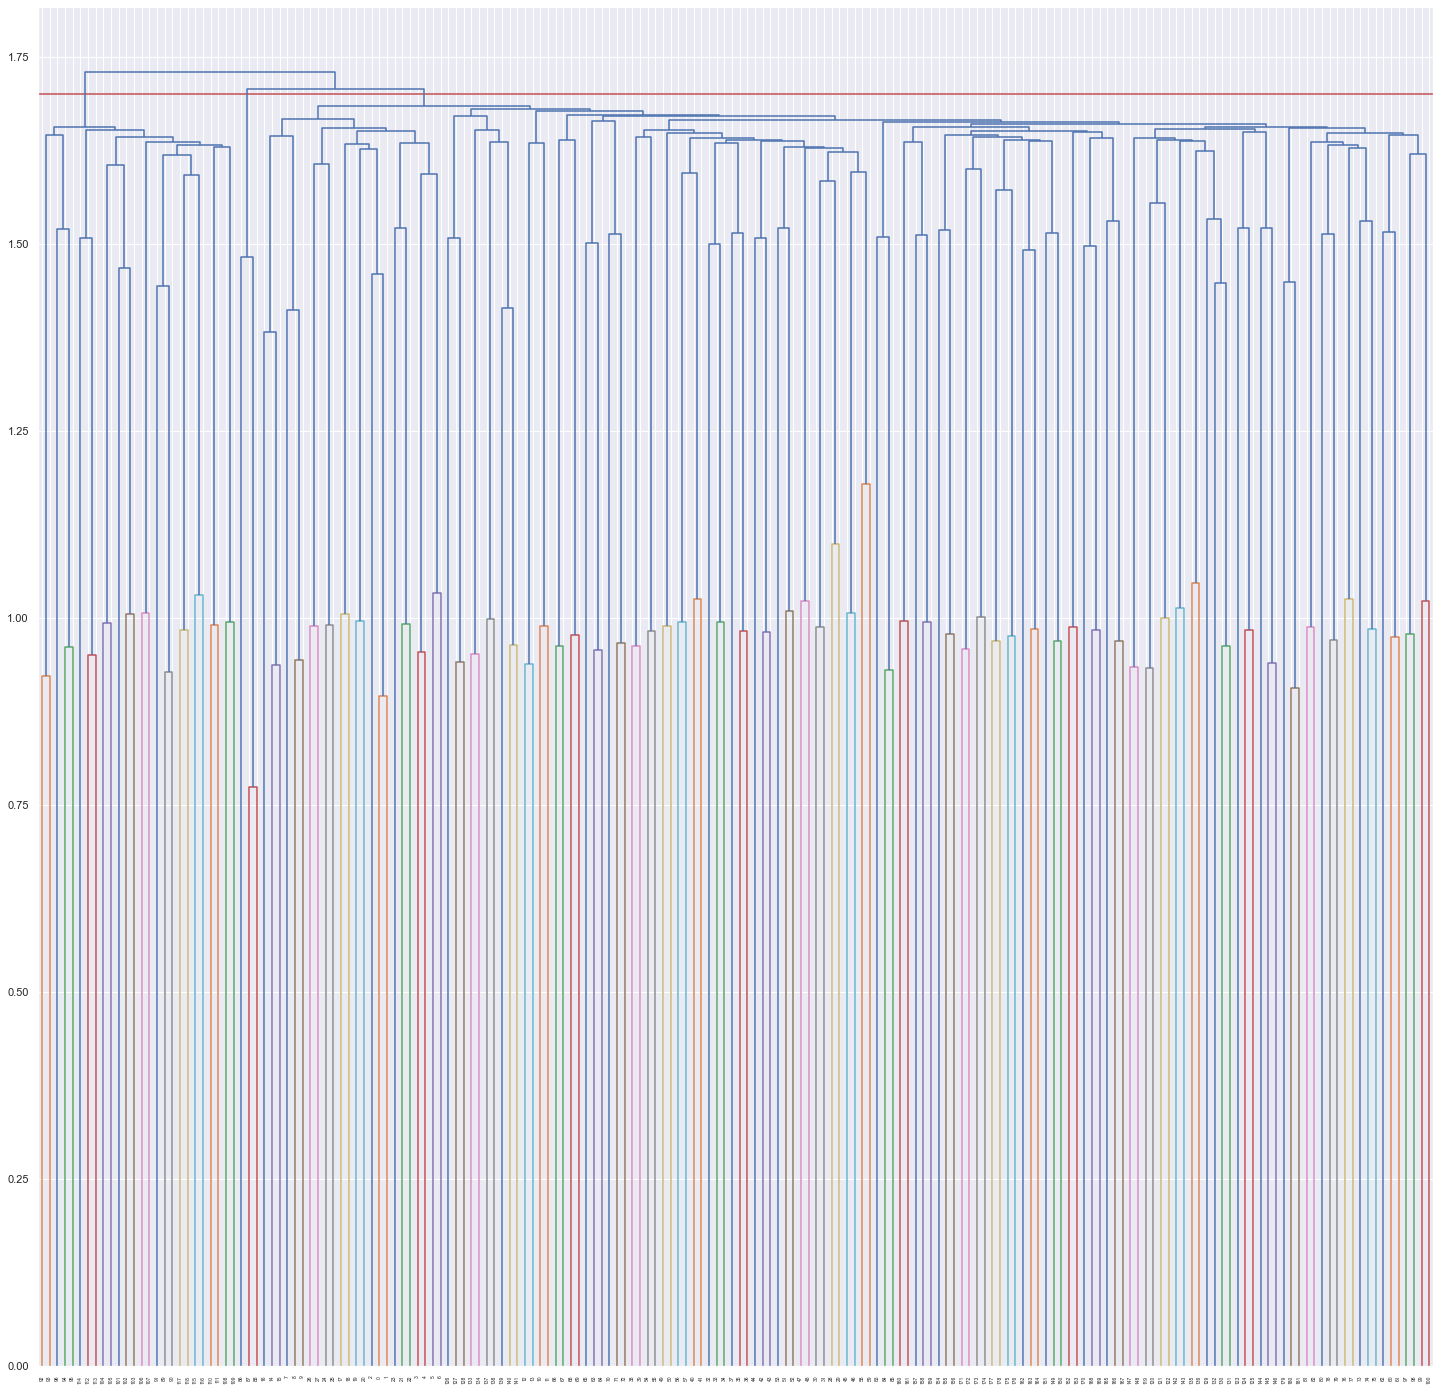

In [61]:
Z = hierarchy.linkage(distance_matrix, 'complete')
plt.figure()
plt.axhline(y =1.7, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

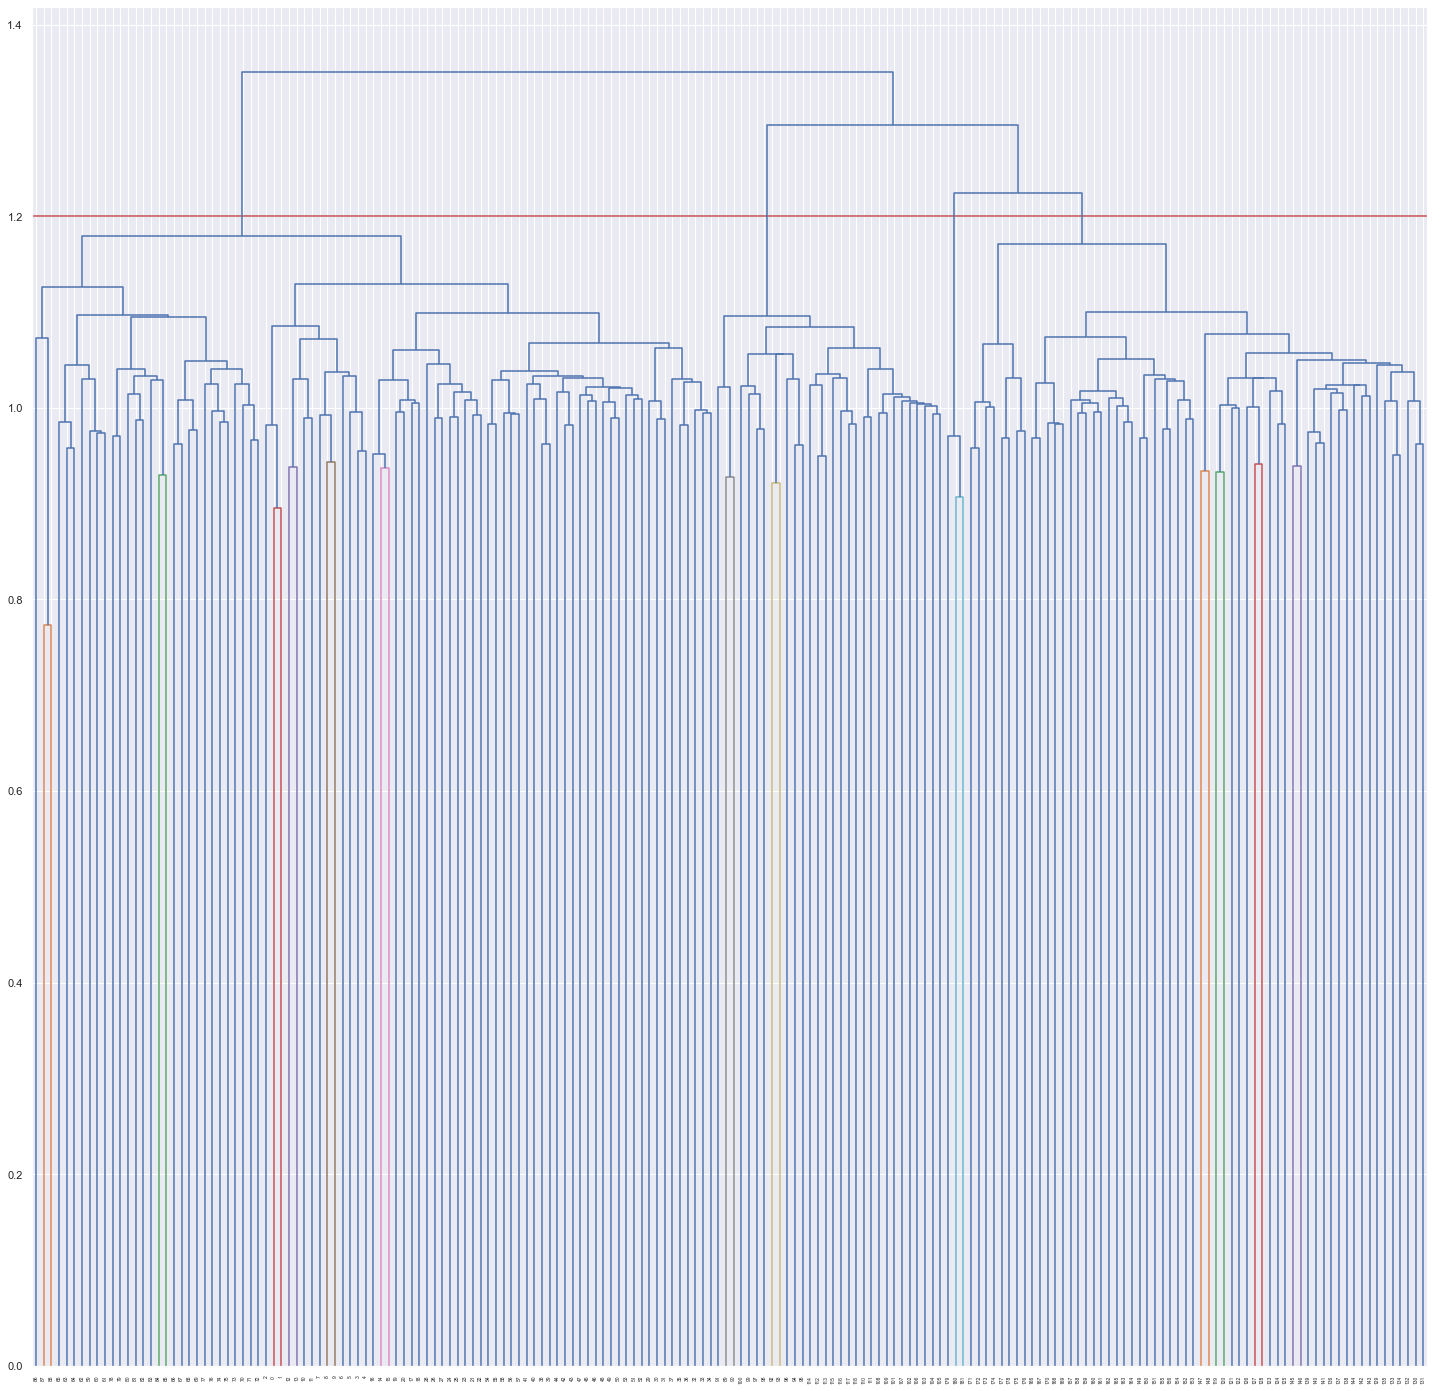

In [62]:
Z = hierarchy.linkage(distance_matrix, 'single')
plt.figure()
plt.axhline(y =1.2, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

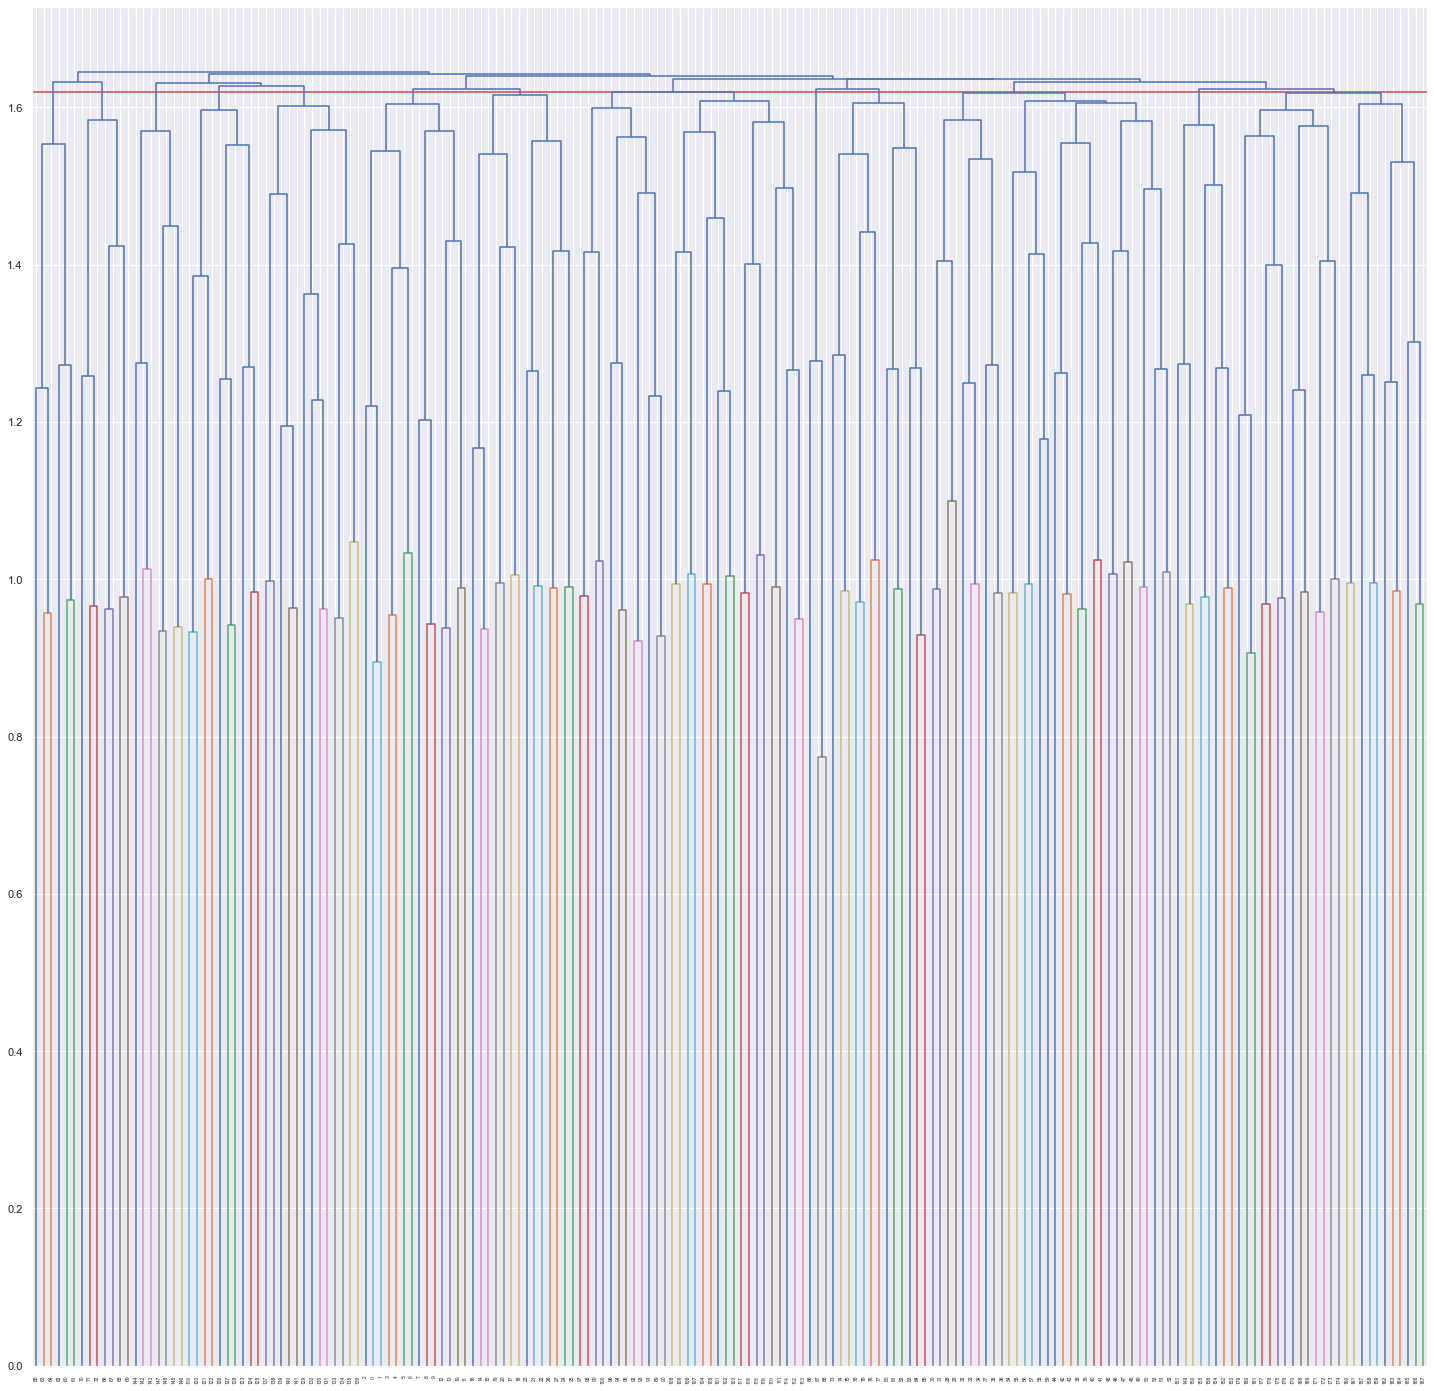

In [64]:
Z = hierarchy.linkage(distance_matrix, 'average')
plt.figure()
plt.axhline(y =1.62, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

In [65]:
clustering = AgglomerativeClustering(n_clusters=4,linkage='single').fit(distance_matrix)
node_targets=clustering.labels_

In [66]:
dict_train=dict(zip(df_train['day'].unique(),node_targets))
cluster_details_train=[]
for i in df_train['day']:
    cluster_details_train.append(dict_train[i])
df_train['cluster_label']=cluster_details_train

In [67]:
df_train['cluster_label'].value_counts()

0    312574
1    171828
2     98027
3      8111
Name: cluster_label, dtype: int64

## Visualization Using t-SNE

In [73]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(distance_matrix)

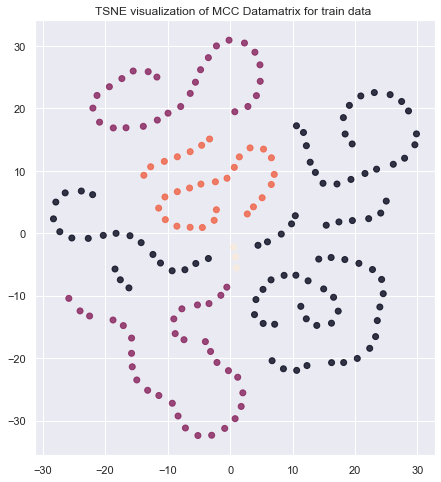

In [74]:
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(12,8))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.8)
plt.title('{} visualization of MCC Datamatrix for train data '.format(transform.__name__))

plt.show()

## Clustering analysis for test data

### Train data has 182 days and Test data starts from 213th day and it has 183 days of transcation data 

In [29]:
distance_matrix_test=np.zeros((183, 183))
df_unique=df_test['day'].unique()-212
df_test['day']=df_test['day'].apply(lambda x:x-212)

In [31]:
for row in df_unique:
    length=int(len(df_test.loc[df_test['day']==row])*0.8)
    X_train1=df_test.loc[df_test['day']==row].drop(['TransactionID','day','week','week2','hour'],axis=1)[:length]
    X_test1 =df_test.loc[df_test['day']==row].drop(['TransactionID','day','week','week2','hour'],axis=1)[length:]
    y_train1=df_test.loc[df_test['day']==row]['day'][:length]
    y_actual1=df_test.loc[df_test['day']==row]['day'][length:]
    for column in df_unique:
        length1=int(len(df_test.loc[df_test['day']==column])*0.8)
        X_train2=df_test.loc[df_test['day']==column].drop(['TransactionID','day','week','week2','hour'],axis=1)[:length1]
        X_test2 =df_test.loc[df_test['day']==column].drop(['TransactionID','day','week','week2','hour'],axis=1)[length1:]
        y_train2=df_test.loc[df_test['day']==column]['day'][:length1]
        y_actual2=df_test.loc[df_test['day']==column]['day'][length1:]
        X_train=np.vstack((X_train1,X_train2))
        X_test=np.vstack((X_test1,X_test2))
        y_train=np.concatenate((y_train1.values,y_train2.values))
        y_actual=np.concatenate((y_actual1.values,y_actual2.values))
        clf = RandomForestClassifier(max_depth=100, random_state=0,min_samples_leaf=10)
        clf.fit(X_train, y_train)
        y_predicted=clf.predict(X_test)
        distance_matrix_test[row-1][column-1]=matthews_corrcoef(y_actual, y_predicted)


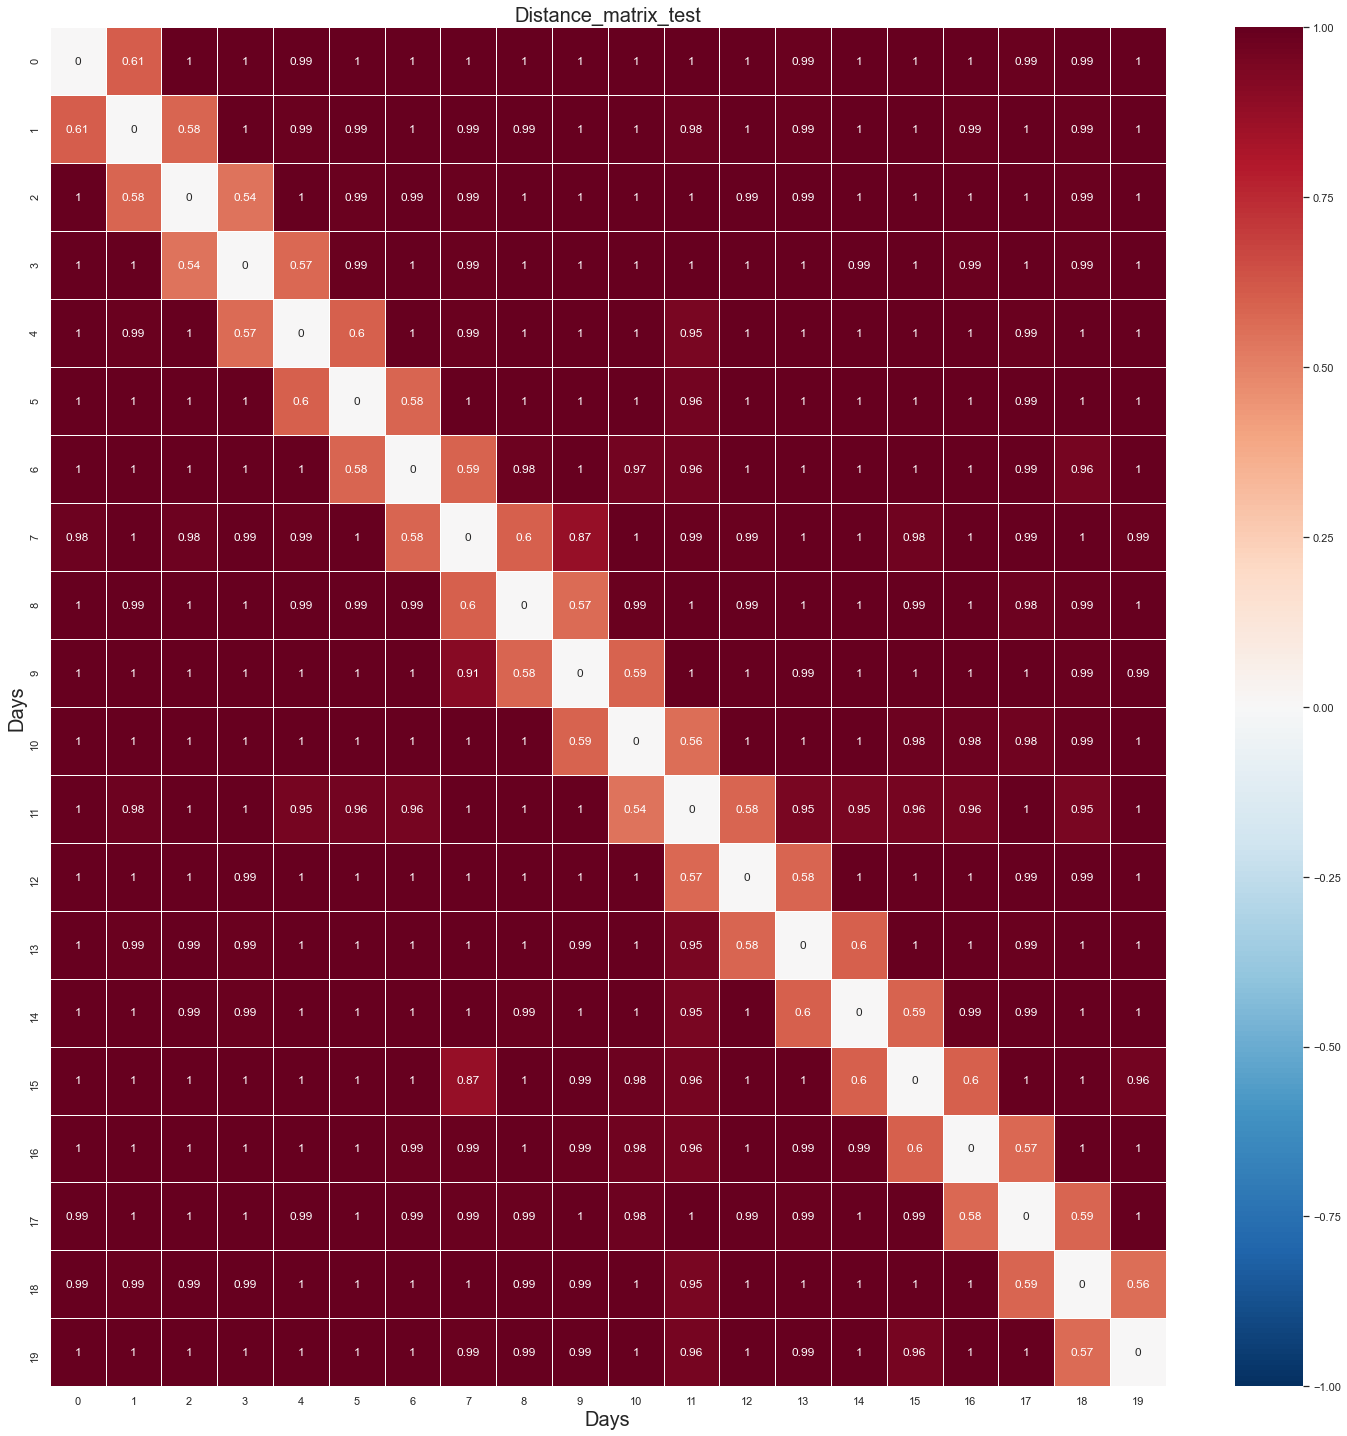

In [20]:
sns.set(rc={'figure.figsize': (25,25)})
sns.heatmap(distance_matrix_test[:20,:20], cmap="RdBu_r", annot=True, linewidths=1,vmin = -1 , vmax = 1)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Days',fontsize=20)
plt.title('Distance_matrix_test',fontsize=20)
plt.show()

## Create new feature from cluster labels

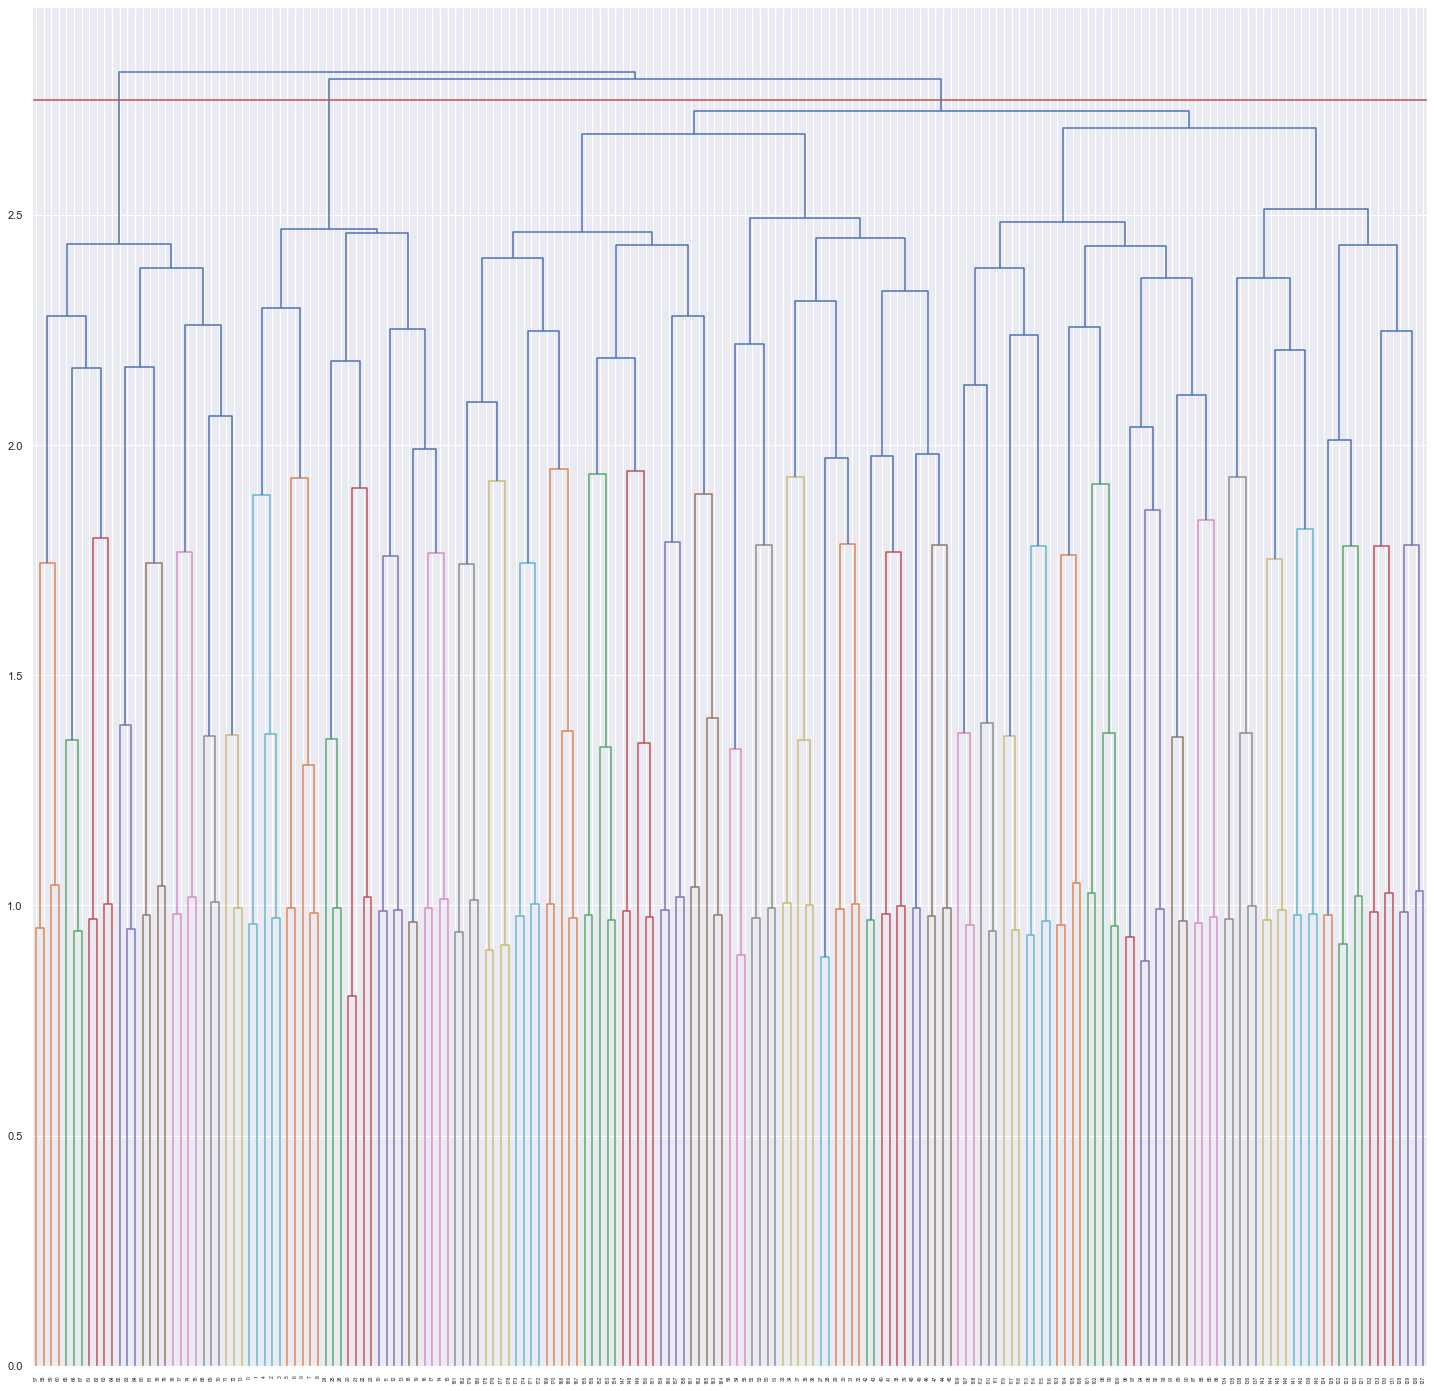

In [76]:
Z = hierarchy.linkage(distance_matrix_test, 'ward')
plt.figure()
plt.axhline(y =2.75, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

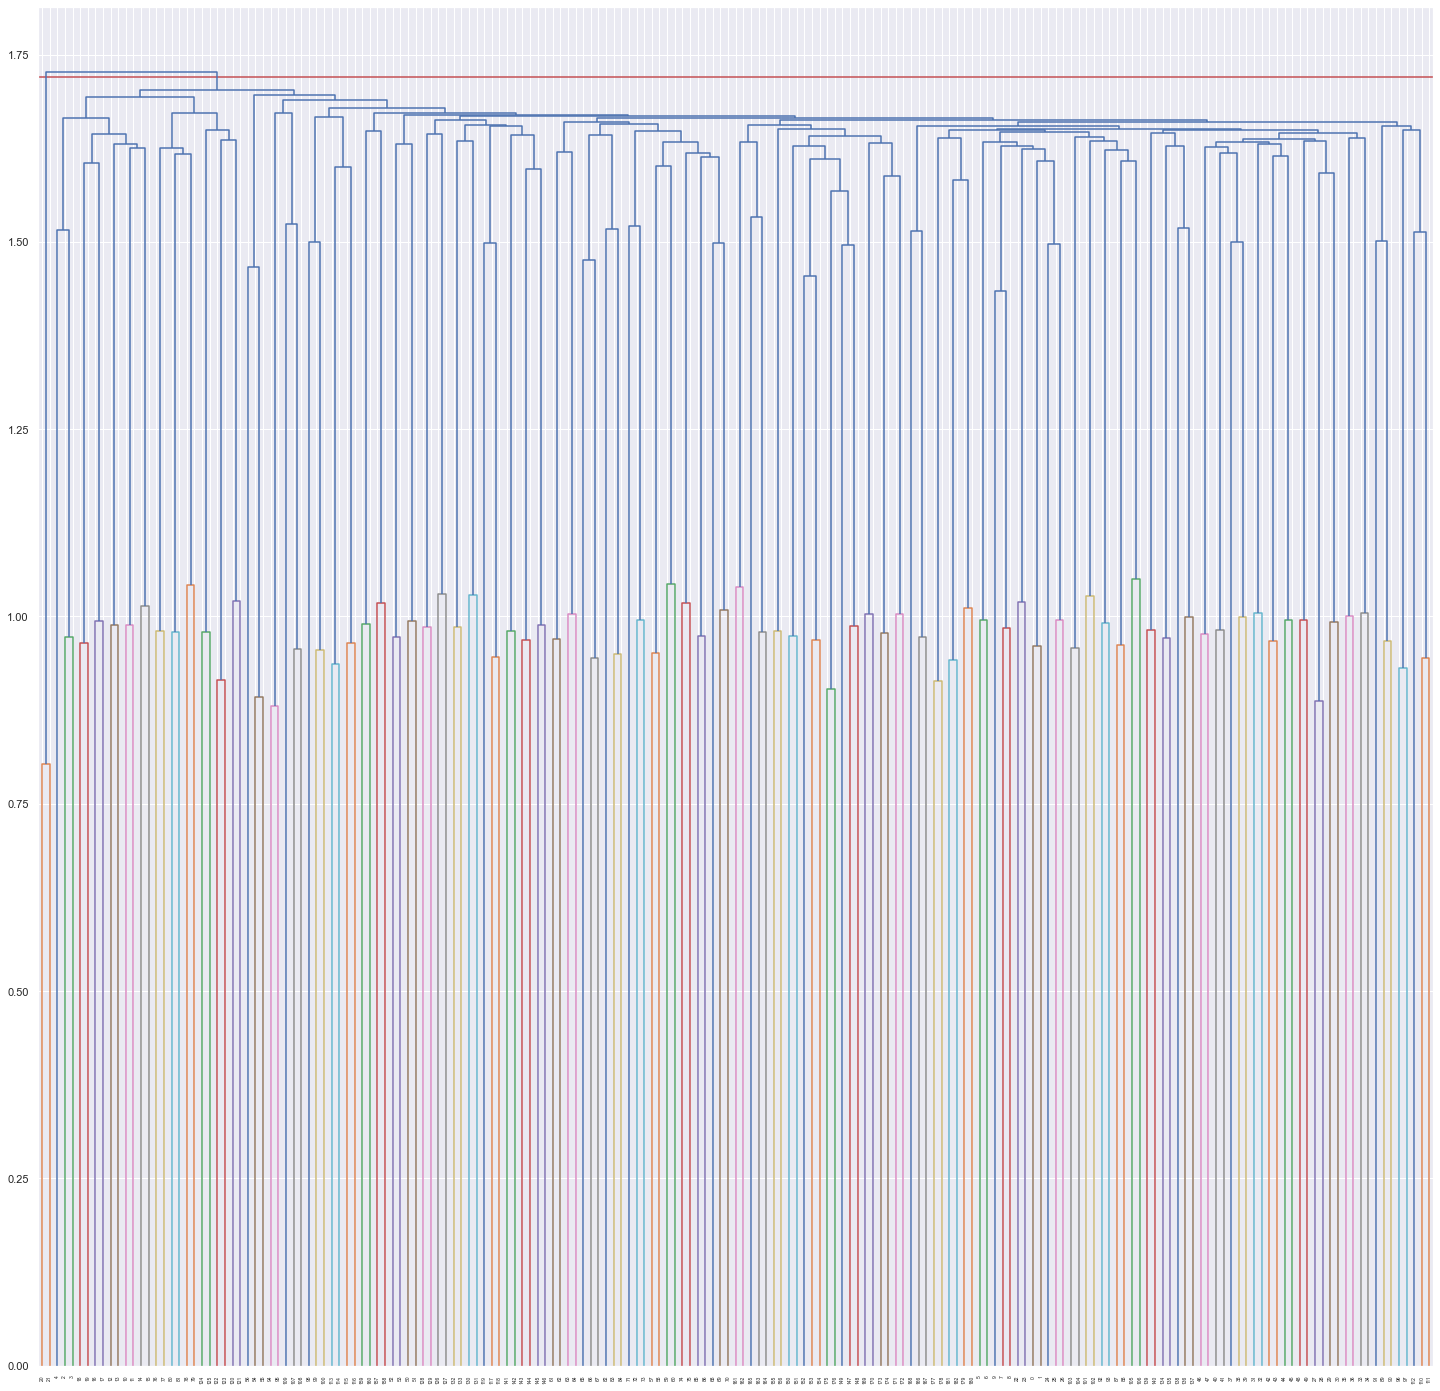

In [77]:
Z = hierarchy.linkage(distance_matrix_test, 'complete')
plt.figure()
plt.axhline(y =1.72, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

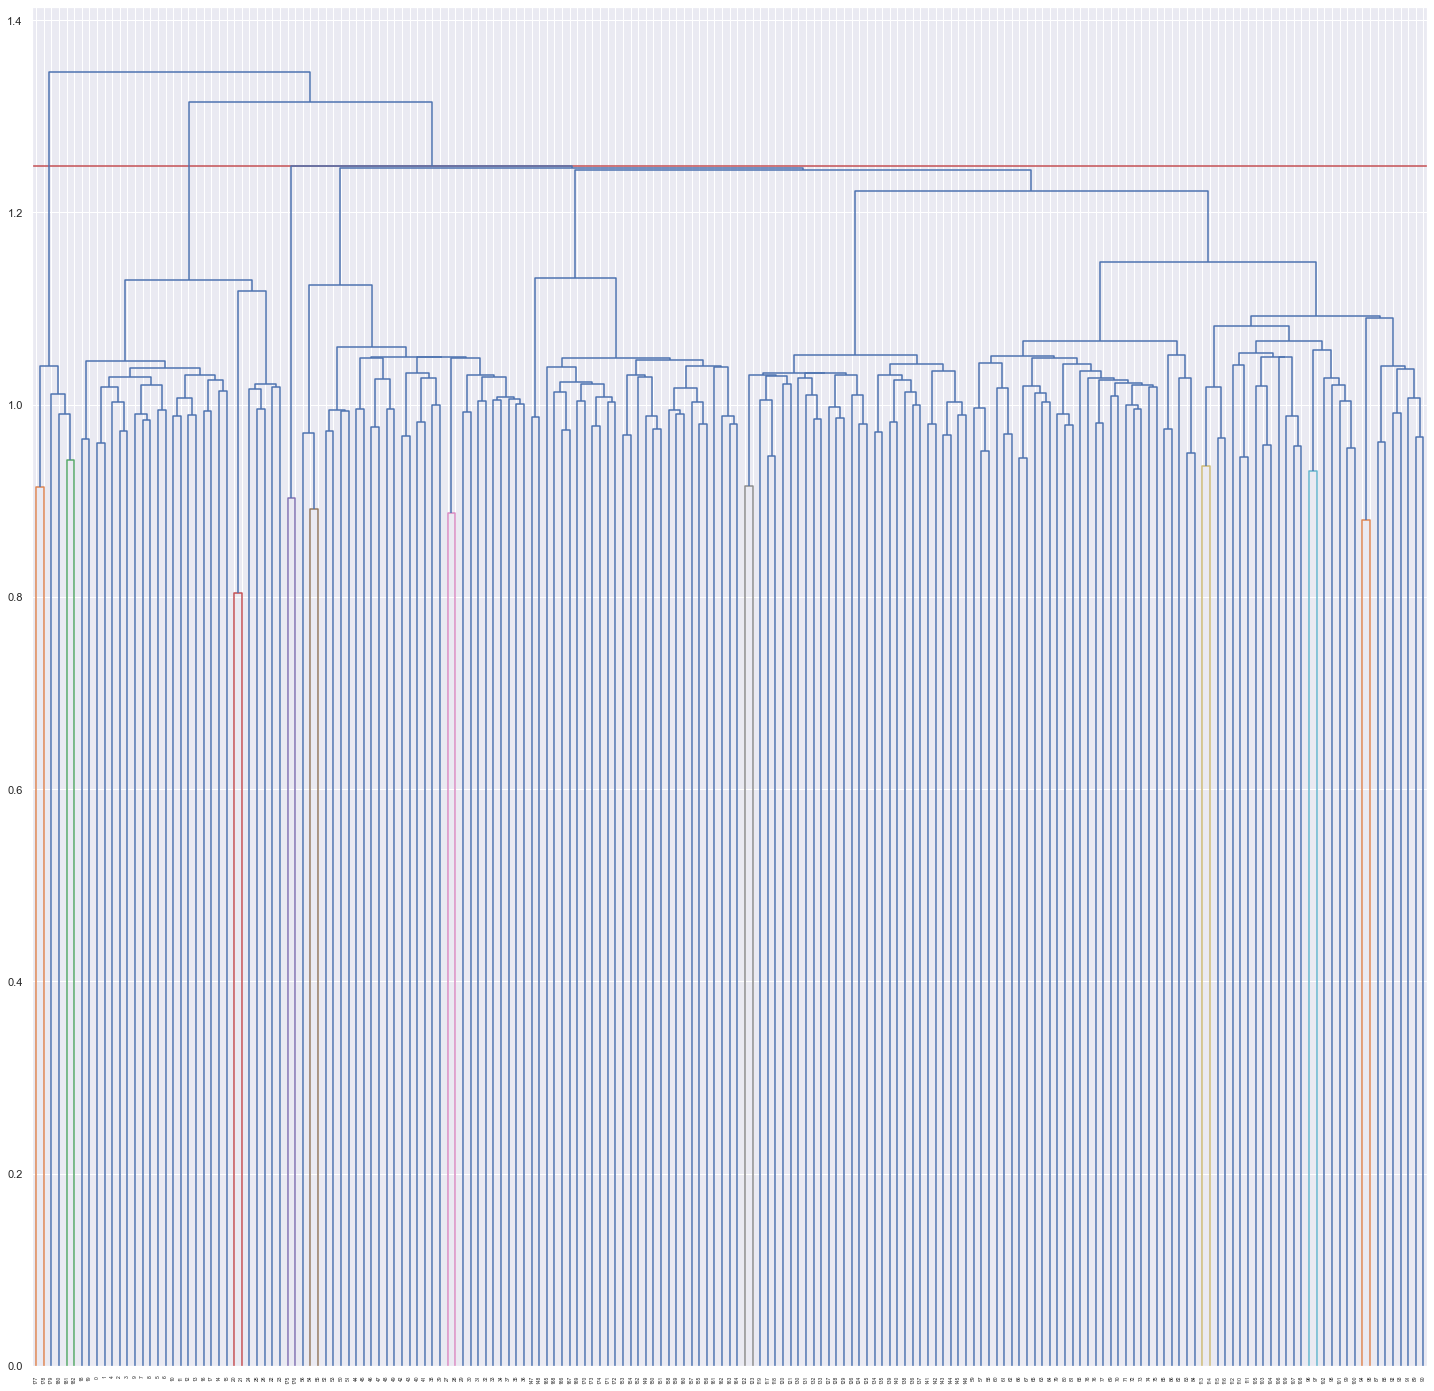

In [57]:
Z = hierarchy.linkage(distance_matrix_test, 'single')
plt.figure()
plt.axhline(y =1.248, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

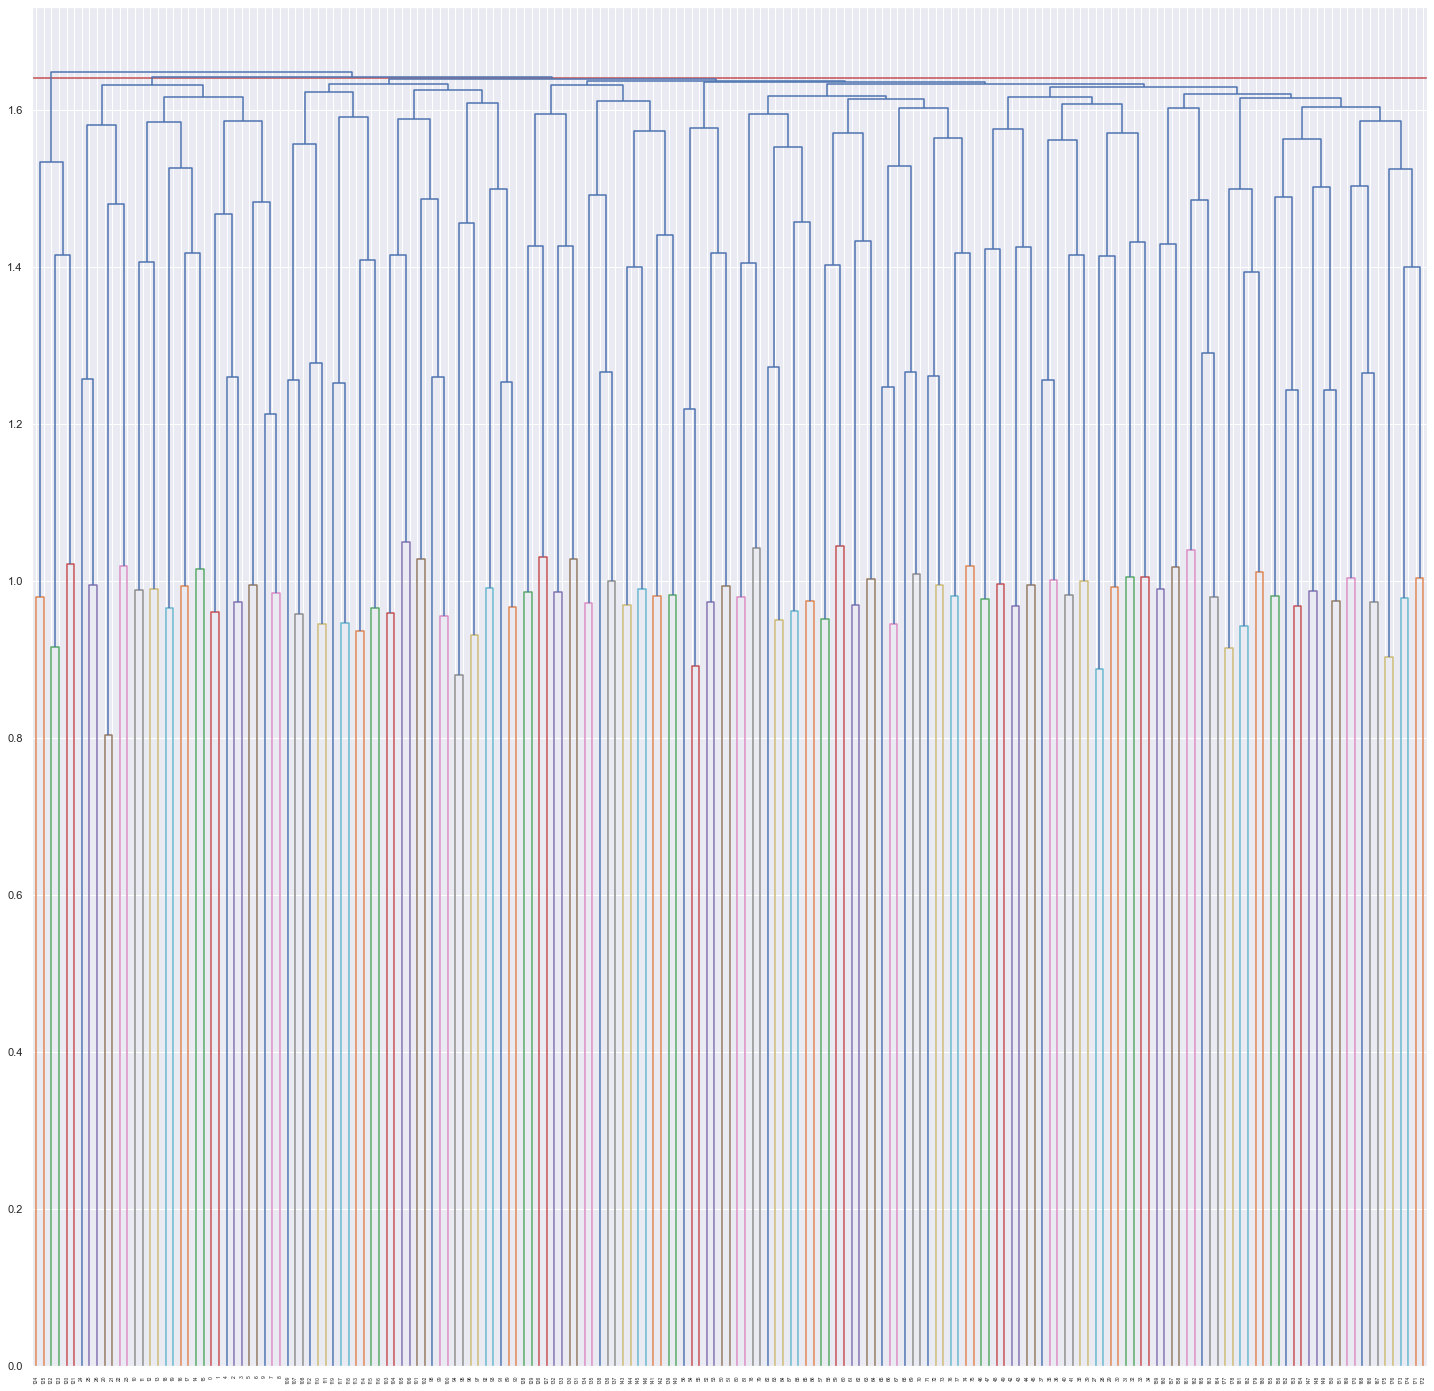

In [79]:
Z = hierarchy.linkage(distance_matrix_test, 'average')
plt.figure()
plt.axhline(y =1.64, color = 'r', linestyle = '-')
dn = hierarchy.dendrogram(Z)

In [98]:
clustering = AgglomerativeClustering(n_clusters=4,linkage='single').fit(distance_matrix_test)
node_targets=clustering.labels_

In [99]:
dictt=dict(zip(df_test['day'].unique(),node_targets))
cluster_details=[]
for i in df_test['day']:
    cluster_details.append(dictt[i])
df_test['cluster_label']=cluster_details

## Visualization using t-SNE

In [100]:
transform = TSNE #PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(distance_matrix_test)

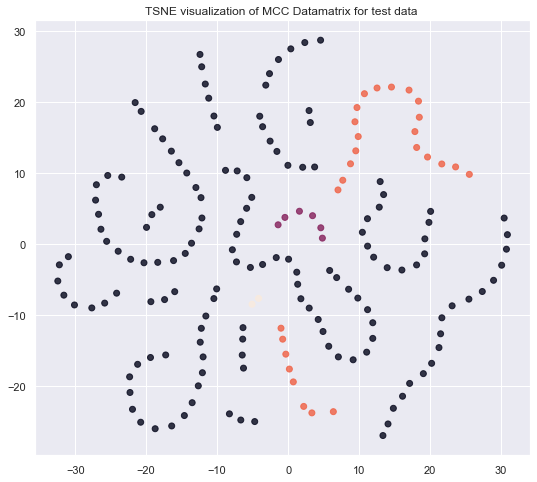

In [101]:
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(12,8))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.8)
plt.title('{} visualization of MCC Datamatrix for test data '.format(transform.__name__))

plt.show()

In [5]:
# load pickled data from Featureengineering file add newly created feature to it
df_train= pd.read_pickle('df_train_fe.pkl')
df_test= pd.read_pickle('df_test_fe.pkl')

In [6]:
df_train=df_train.merge(df_train[['TransactionID','cluster_label']],on='TransactionID')
df_train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,#tran_1day,Act_amt/Avg_amt,#tran_1day_addr2,Maxamt_14day_addr2,Medianamt_30day_addr1,Totalamt_30day_addr1,log_amt,ConfidenceInterval,binary_feature,cluster_label
0,2987000,0,86400,68.5,4,13926,361.0,150.0,1,142.0,...,1,1.0,1,68.5,68.5,68.5,4.226834,[-0. 0.],True,0
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,1,1.0,1,29.0,29.0,29.0,3.367296,[-0. 0.],True,0


In [7]:
df_test=df_test.merge(df_test[['TransactionID','cluster_label']],on='TransactionID')
df_test.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,Act_amt/Avg_amt,#tran_1day_addr2,Maxamt_14day_addr2,Medianamt_30day_addr1,Medianamt_30day,Totalamt_30day_addr1,log_amt,ConfidenceInterval,binary_feature,cluster_label
0,3663549,18403224,31.95,4,10409,111.0,150.0,4,226.0,2,...,2.0,1,31.95,33.95,33.95,67.9,3.464172,[-0. 0.],True,2
1,3700040,19618316,35.95,4,10409,111.0,150.0,4,226.0,2,...,2.0,1,35.95,33.95,33.95,67.9,3.582129,[12. 16.],False,2


In [8]:
df_train.to_pickle('df_train_final.pkl')
df_test.to_pickle('df_test_final.pkl')

## Combining Clusters in the Agglomerative Approach
1) From Calender events we can divide days into weekdays saturday sunday holiday i.e we can group our data into 4 clusters.
2) In single linkage we cut the dendogram at a inter cluster distance 1.2 for train data 1.248 for test data.
3) Using single linkage and cutting dendrogarm at above distance,represents the calender events better.